In [93]:
%load_ext autoreload
%autoreload 2

import numpy as np
from idqn.utils.dopamine_scores import get_dopamine_scores

dopamine_baselines = ["DQN (Adam + MSE in JAX)", "C51", "Rainbow", "Quantile (JAX)", "IQN", "DQN"]
experiments = ["ut30_uh6000"]
games = [
    "Bowling"
]
ks = [5]
seeds = [11, 21]
plot_std = False
selected_epochs = np.array([1, 10, 25, 50, 75, 100, 125, 150, 175, 199]) - 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Extract data

In [94]:
from idqn.utils.dopamine_scores import get_dopamine_scores


dopamine_js = {}
for dopamine_baseline in dopamine_baselines:
    dopamine_js[dopamine_baseline] = {}
    for game in games:
        dopamine_js[dopamine_baseline].update(get_dopamine_scores(game, dopamine_baseline))

idqn_js = {}
for experiment in experiments:
    for k in ks:
        idqn_js[f"{experiment}_{k}"] = {}
        for game in games:
            for seed in seeds:
                idqn_js[f"{experiment}_{k}"][f"{game}_{seed}"] = np.load(f"figures/{experiment}/{game}/iDQN/{k}_J_{seed}.npy")

/home/vincent/iDQN/env_cpu/lib/python3.8/site-packages/scipy/stats/_resampling.py:97: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))


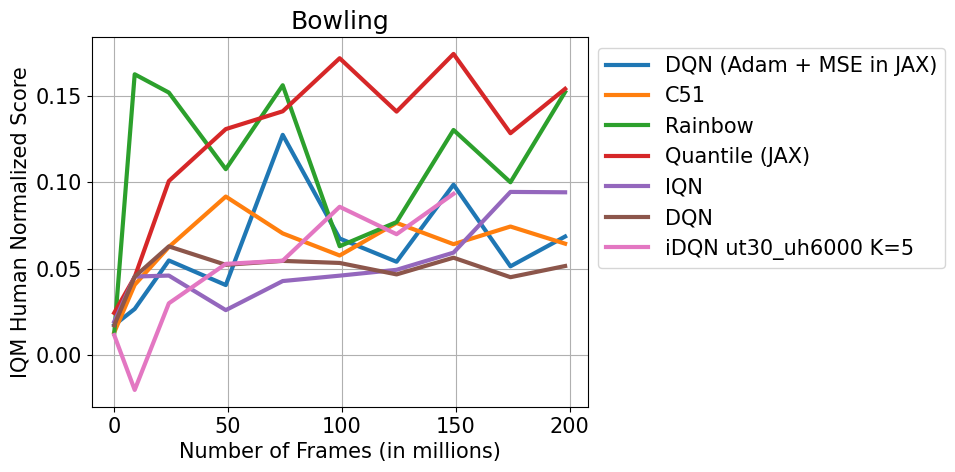

In [95]:
import matplotlib.pyplot as plt
from idqn.utils.plots import compute_iqm_and_confidence_interval

plt.rc("font", size=15)
plt.rc("lines", linewidth=3)

for dopamine_baseline in dopamine_baselines:
    iqms, iqms_confidence_interval = compute_iqm_and_confidence_interval(dopamine_js[dopamine_baseline], selected_epochs)
    plt.plot(selected_epochs, iqms, label=dopamine_baseline)
    if plot_std:
        plt.fill_between(selected_epochs, iqms_confidence_interval[0, :], iqms_confidence_interval[1, :], alpha=0.3)

for experiment in experiments:
    for k in ks:
        iqms, iqms_confidence_interval = compute_iqm_and_confidence_interval(idqn_js[f"{experiment}_{k}"], selected_epochs)
        plt.plot(selected_epochs, iqms, label=f"iDQN {experiment} K={k}")
        if plot_std:
            plt.fill_between(selected_epochs, iqms_confidence_interval[0, :], iqms_confidence_interval[1, :], alpha=0.3)


plt.grid()
plt.xlabel("Number of Frames (in millions)")
plt.ylabel("IQM Human Normalized Score")
if len(games) == 1:
    plt.legend(bbox_to_anchor=[1, 1])
    plt.title(games[0])
    _ = plt.savefig(f"figures/{experiments[0]}/{games[0]}/J.pdf", bbox_inches='tight')
else:
    plt.legend(ncols=len(dopamine_baselines) + len(experiments) + len(ks), bbox_to_anchor=[1, 1])
    _ = plt.savefig(f"figures/{experiments[0]}/J.pdf", bbox_inches='tight')